In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
import kagglehub 
import urllib

/Users/evanlynch/Library/CloudStorage/OneDrive-Personal/Python/stock-predictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Alpha Vantage API Key
key = '61QSG0UFUU2IQB41'

# Import only stocks data from Kaggle dataset
path = kagglehub.dataset_download(
    "borismarjanovic/price-volume-data-for-all-us-stocks-etfs")

print("Path to dataset files:", path)

Path to dataset files: /Users/evanlynch/.cache/kagglehub/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/versions/3


In [3]:
data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '61QSG0UFUU2IQB41'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')


File already exists. Loading data from CSV


In [4]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
4960,0,2005-09-27,19.10,21.40,19.30,21.05
4959,1,2005-09-28,19.20,20.53,20.50,19.30
4958,2,2005-09-29,20.10,20.58,20.21,20.40
4957,3,2005-09-30,20.18,21.05,21.01,20.26
4956,4,2005-10-03,20.90,21.75,21.50,20.90


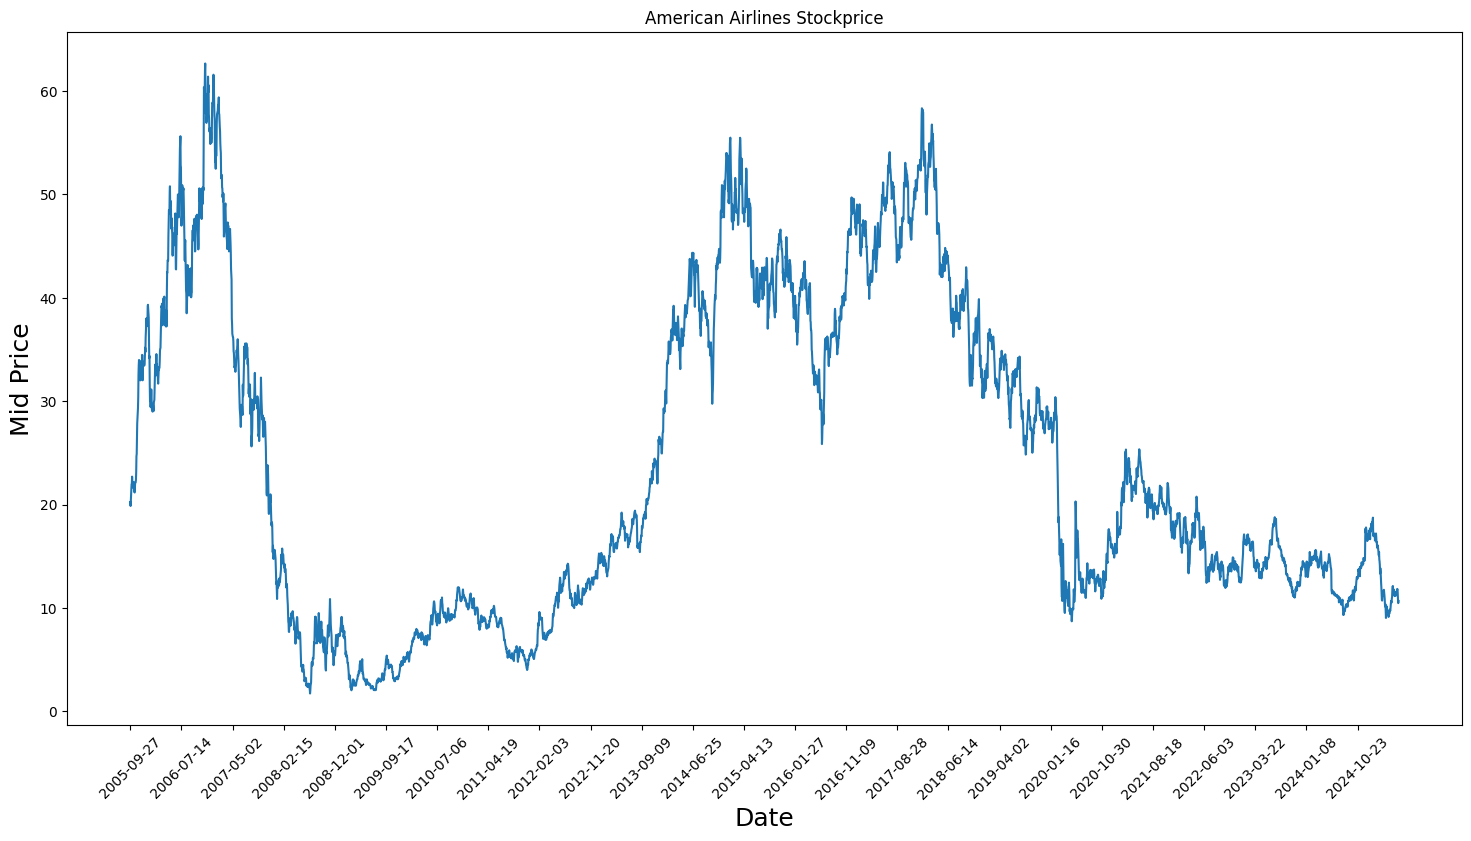

In [10]:
plt.figure(figsize = (18,9))
plt.title('American Airlines Stockprice')
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],200),df['Date'].loc[::200],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [6]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices + low_prices)/2.0

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(mid_prices, train_size=0.5, random_state=42)

In [33]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train.reshape(-1,1)
test_data = test.reshape(-1,1)


In [34]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 500

# Check if we have enough data
if len(train_data) < smoothing_window_size:
    raise ValueError(f"Not enough training data. Need at least {smoothing_window_size} samples")

# Normalize data in windows
for di in range(0, len(train_data), smoothing_window_size):
    end_idx = min(di + smoothing_window_size, len(train_data))
    scaler.fit(train_data[di:end_idx,:])
    train_data[di:end_idx,:] = scaler.transform(train_data[di:end_idx,:])

# No need for additional normalization of remaining data since we're using
# range(0, len(train_data), smoothing_window_size) which handles all data

In [39]:
# Reshape train data
train_data = train_data.reshape(-1)

# Reshape test data to 2D array for scaling
test_data = test_data.reshape(-1, 1)

# Fit and transform test data
scaler.fit(test_data)
test_data = scaler.transform(test_data).reshape(-1)

In [43]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1

# Use the actual length of train_data instead of hardcoded value
for ti in range(len(train_data)):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [49]:
window_size = 1000
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for standard averaging: 0.00084


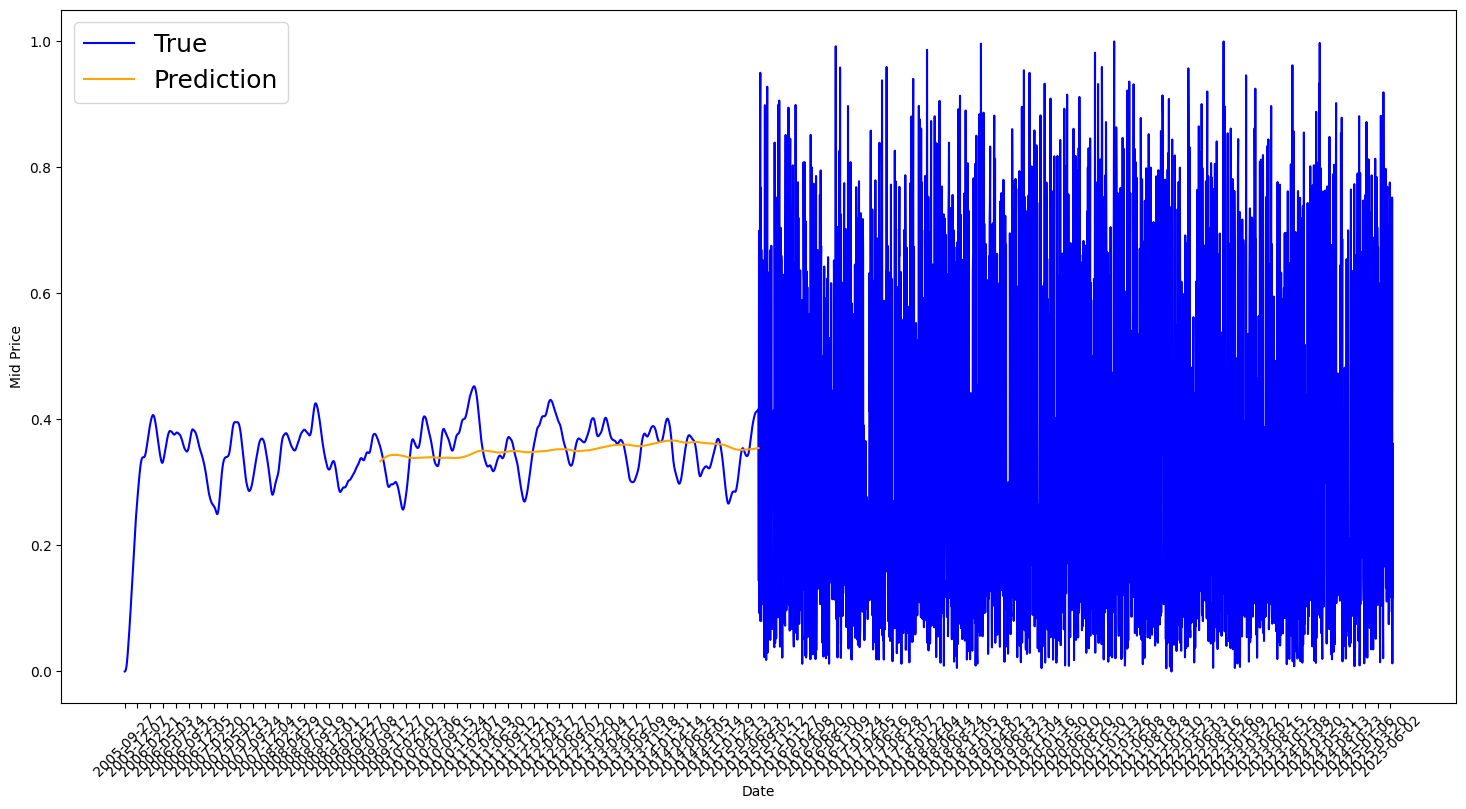

In [50]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [32]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2000
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed